In [1]:
import os
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import ts2xy, load_results

env = gym.make('MountainCarContinuous-v0')

model_1 = SAC.load("model_1")
model_2 = SAC.load("model_2")
model_3 = SAC.load("model_3")
model_4 = SAC.load("model_4")
model_5 = SAC.load("model_5")
model_6 = SAC.load("model_6")

In [2]:
# Prepare base directory for logs
base_log_dir  = "./model_logs/"
os.makedirs(base_log_dir, exist_ok=True)

In [3]:
# Function to reset the environment with a new monitor
def reset_env_with_monitor(env, log_dir):
    return Monitor(env, log_dir)


def train_model(model, env, total_timesteps=10000):
    model.set_env(env)  
    model.learn(total_timesteps)


# Function to transfer weights
def transfer_weights(source_model, target_model):
    weights_source = source_model.policy.state_dict()
    weights_target = target_model.policy.state_dict()
    for name, param in weights_source.items():
        if name in weights_target and param.data.shape == weights_target[name].data.shape:
            weights_target[name].data.copy_(param.data)
    target_model.policy.load_state_dict(weights_target, strict=False)


def save_model(model, model_name):
    model.save(model_name)

In [4]:
# Load models
model_names = ["Network 1 + 3", "Network 3 + 5", "Network 2 + 4", "Network 4 + 6"]
models_to_train = [model_3, model_5, model_4, model_6]
models_to_transfer_from = [model_1, model_3, model_2, model_4]

for model, model_to_transfer_from, model_name in zip(models_to_train, models_to_transfer_from, model_names):
    # Create environment with monitor
    log_dir = os.path.join(base_log_dir, model_name)
    os.makedirs(log_dir, exist_ok=True)
    env = reset_env_with_monitor(gym.make('MountainCarContinuous-v0'), log_dir)
    
    # Transfer weights and train
    transfer_weights(model_to_transfer_from, model)
    train_model(model, env, total_timesteps=3000) # Use 3000 timesteps

    save_model(model, model_name)

Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.
Wrapping the env in a DummyVecEnv.


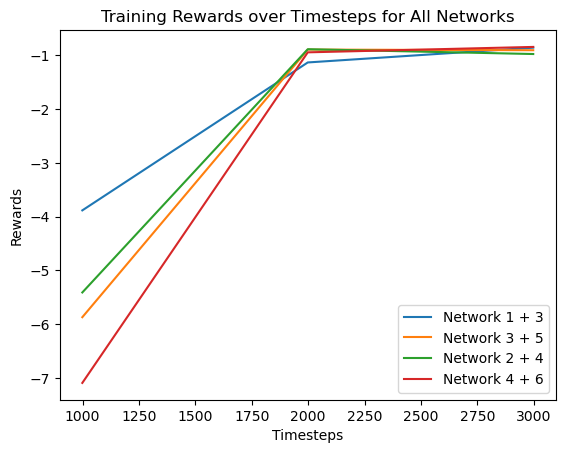

In [5]:
# Function to plot rewards
def plot_rewards(log_dirs, model_names, title="Training Rewards"):
    for log_dir, model_name in zip(log_dirs, model_names):
        x, y = ts2xy(load_results(log_dir), "timesteps")
        plt.plot(x, y, label=model_name)
    
    plt.xlabel("Timesteps")
    plt.ylabel("Rewards")
    plt.title(title)
    plt.legend()
    plt.savefig('ann_4.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create list of log directories
log_dirs = [os.path.join(base_log_dir, model_name) for model_name in model_names]

# Plot the rewards
plot_rewards(log_dirs, model_names, title="Training Rewards over Timesteps for All Networks")

In [6]:
# Define the evaluation function
def evaluate_model(model, num_episodes=100): # Use 100 episodes
    episode_rewards = []
    for i in range(num_episodes):
        obs = env.reset()
        done = False
        total_rewards = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, info = env.step(action)
            total_rewards += reward
        episode_rewards.append(total_rewards)
    return np.mean(episode_rewards), np.std(episode_rewards)

In [7]:
# Evaluate all the models
evaluations = []
for model, model_name in zip(models_to_train, model_names):
    mean_reward, std_dev = evaluate_model(model)
    evaluations.append((model_name, mean_reward, std_dev))
    print(f'Network: {model_name}: Average Reward = {mean_reward:.5f}, Standard Deviation = {std_dev:.5f}')

Network: Network 1 + 3: Average Reward = -0.91448, Standard Deviation = 0.04336
Network: Network 3 + 5: Average Reward = -0.84771, Standard Deviation = 0.03998
Network: Network 2 + 4: Average Reward = -0.94211, Standard Deviation = 0.03700
Network: Network 4 + 6: Average Reward = -0.78660, Standard Deviation = 0.03423


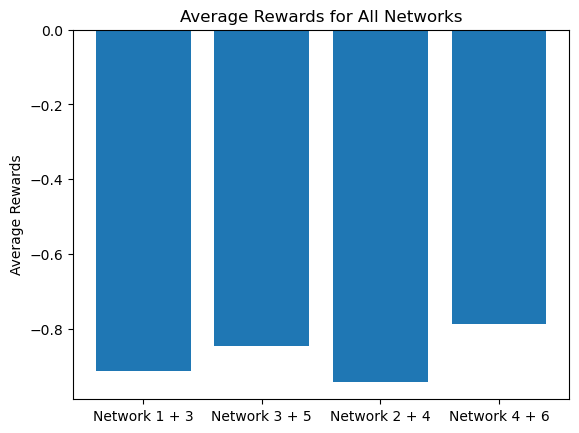

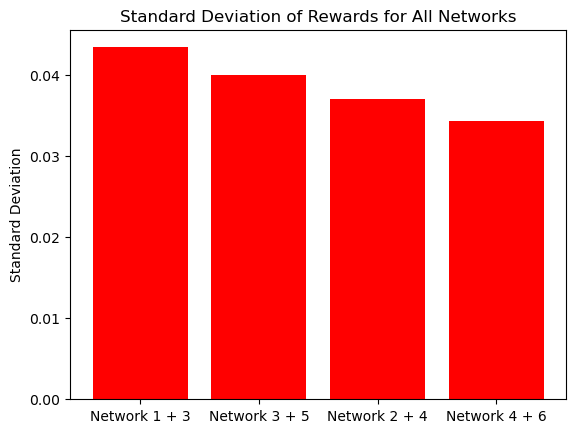

In [8]:
# Define the plotting function for average rewards and standard deviations separately
def plot_evaluations(evaluations):
    model_names, means, std_devs = zip(*evaluations)
    
    # Plot for average rewards
    plt.bar(model_names, means)
    plt.ylabel('Average Rewards')
    plt.title('Average Rewards for All Networks')
    plt.savefig('ann_5.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot for standard deviations
    plt.bar(model_names, std_devs, color='red')
    plt.ylabel('Standard Deviation')
    plt.title('Standard Deviation of Rewards for All Networks')
    plt.savefig('ann_6.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot the evaluations
plot_evaluations(evaluations)